In [2]:
"""
Made on July 10th, 2019
@author: Theodore Pena
@contact: theodore.pena@tufts.edu
"""
print()

# Setup and imports

In [6]:
import sys
print("sys version: {}".format(sys.version))
# This project is entirely in python 3.7

import matplotlib
import matplotlib.pyplot as plt
%matplotlib qt 
# If you don't have an X server, line 7 might crash your kernel. Try '%matplotlib inline' instead.

import numpy as np
print("numpy version: {}".format(np.__version__))

import pandas as pd
print("pandas version: {}".format(pd.__version__))

from tqdm import tqdm
# This gives for loops progress bars.

import random
# This helps choosing random numbers from our arrays
random.seed(565) # Set random seed for reproducibility

from IPython.core.display import display, HTML
# An alternate, cleaner take on the jupyter workspace
display(HTML("<style>.container { width:100% !important; }</style>"))

sys version: 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy version: 1.16.2
pandas version: 0.24.2


In [4]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

# Data extraction

## Wolfram style

In [43]:
# Variables
brightest_percent = .1 # Out of the entire sample, the program will randomly choose from the brightest (brightest_percent)%. Setting this to 100 means that we choose randomly from the whole sample. 
num_random_points = 1000 # This is the number of points that are randomly choosen from the light curve
t_max = 10000 # The last number in the sequence 5, 10, ..., 1000 (the point furthest from each chosen point)
t_step = 10 # The diffrence between two points in the sequence 5, 10, ...
length_curve = 2**24 # Number of points in the curve
num_curves = 20 # Number of curves we're examining

In [44]:
# Load the data
default_curves = []
for i in tqdm(range(num_curves + 1)):
    
    if i == 0:
        continue # for some reason the results files start at 1 and not 0
        
    _er_curve = np.zeros(length_curve, dtype=float)
    _er_curve = np.fromfile('/home/tpena01/AGN_variability_project/Simulations/light_curves/default_params/results_Default_curve_{}.bin'.format(str(i)))
    default_curves.append(_er_curve)

default_curves = np.array(default_curves)

default_curves = np.log10(default_curves) # Move everything into the log domain

100%|██████████| 21/21 [00:03<00:00,  7.71it/s]


In [45]:
# Cut out the last t_max points
cut_curves = np.zeros((np.array(list(default_curves.shape)) - np.array([0, t_max])))
for i in tqdm(range(num_curves)):
    cut_curves[i, :] = default_curves[i, :-t_max]

100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


In [46]:
# Select the brightest (brightest_percent)% of points
num_brightest = int(np.floor((cut_curves[0].shape[0] * (brightest_percent/100))))

if brightest_percent == 100:
    num_brightest=cut_curves[0].shape[0]

indices = []
for i in tqdm(range(cut_curves.shape[0])):
    indices.append(np.argpartition(cut_curves[i, :], -num_brightest)[-num_brightest:])

indices = np.array(indices)

100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


In [47]:
# Randomly sample from the chosen indices
chosen_indices = []
for brightest_points_in_curve in tqdm(indices):
    chosen_indices.append(random.sample(list(brightest_points_in_curve), num_random_points))

chosen_indices = np.array(chosen_indices, dtype=int)

100%|██████████| 20/20 [00:00<00:00, 379.68it/s]


In [49]:
# Find the smallest number that we've chosen (We print this out later)
small_points = []
for i in tqdm(range(num_curves)):
    small_points.append(np.min(cut_curves[i][chosen_indices[i]]))

smallest_point = "The smallest log10(Eddington ratio) chosen while making this plot was " + str(np.min(small_points))

100%|██████████| 20/20 [00:00<00:00, 6383.54it/s]


In [10]:
# Select all our points
t_examine = np.logspace(0, np.log10(t_max), t_max/t_step + 1).astype(int)
t_log = np.log10(t_examine) # Used later

t_array = np.tile(t_examine, (num_random_points, 1))

master_array = np.zeros(t_examine.shape, dtype=int)

for i in tqdm(range(num_curves)):
    indices_array = np.tile(chosen_indices[i, :], (t_array.shape[1], 1)).T
    
    indices_array = indices_array + t_array    
    master_array = np.vstack((default_curves[i][indices_array], master_array))

master_array = np.delete(master_array, -1, 0)

starting_vals = np.copy(master_array[:, 0])
for i in tqdm(range(master_array.shape[1])):
    master_array[:, i] = master_array[:, i] - starting_vals

100%|██████████| 201/201 [00:00<00:00, 3810.38it/s]


In [11]:
# Find our trends
means = []
stands = []

for i in tqdm(range(master_array.shape[1])):
    means.append(np.mean(master_array[:, i]))
    stands.append(np.std(master_array[:, i]))

means = np.array(means)
stands = np.array(stands)

100%|██████████| 201/201 [00:00<00:00, 2353.61it/s]


In [12]:
# Get a line of best fit
best_fit = np.poly1d(np.poly1d(np.polyfit(t_log.astype(float)[1:], means.astype(float)[1:], 1)))

## Python style

In [7]:
def generate_curve(brightest_percent=1, num_random_points=1000, t_max=10000, t_step=10, length_curve=2**24, num_curves=20):
    """
    Input: Parameters documented in the cell above
    Output: Graph of delta Eddington ratio as a function of delta time.  
    """
    # Load the data
    default_curves = []
    for i in tqdm(range(num_curves + 1)):

        if i == 0:
            continue # for some reason the results files start at 1 and not 0

        _er_curve = np.zeros(length_curve, dtype=float)
        _er_curve = np.fromfile('/home/tpena01/AGN_variability_project/Simulations/light_curves/default_params/results_Default_curve_{}.bin'.format(str(i)))
        default_curves.append(_er_curve)

    default_curves = np.array(default_curves)

    default_curves = np.log10(default_curves) # Move everything into the log domain
    
    
    # Cut out the last t_max points
    cut_curves = np.zeros((np.array(list(default_curves.shape)) - np.array([0, t_max])))
    for i in tqdm(range(num_curves)):
        cut_curves[i, :] = default_curves[i, :-t_max]
    
    
    # Select the brightest (brightest_percent)% of points
    num_brightest = int(np.floor((cut_curves[0].shape[0] * (brightest_percent/100))))

    if brightest_percent == 100:
        num_brightest=cut_curves[0].shape[0]

    indices = []
    for i in tqdm(range(cut_curves.shape[0])):
        indices.append(np.argpartition(cut_curves[i, :], -num_brightest)[-num_brightest:])

    indices = np.array(indices)
    
    
    # Randomly sample from the chosen indices
    chosen_indices = []
    for brightest_points_in_curve in tqdm(indices):
        chosen_indices.append(random.sample(list(brightest_points_in_curve), num_random_points))

    chosen_indices = np.array(chosen_indices, dtype=int)
    
    
    # Find the smallest number that we've chosen (We print this out later)
    small_points = []
    for i in tqdm(range(num_curves)):
        small_points.append(np.min(cut_curves[i][chosen_indices[i]]))

    smallest_point = "The smallest log10(Eddington) ratio chosen while making this plot was " + str(np.min(small_points))
    
    
    # Select all our points
    t_examine = np.logspace(0, np.log10(t_max), t_max/t_step + 1).astype(int)
    t_log = np.log10(t_examine) # Used later

    t_array = np.tile(t_examine, (num_random_points, 1))

    master_array = np.zeros(t_examine.shape, dtype=int)

    for i in tqdm(range(num_curves)):
        indices_array = np.tile(chosen_indices[i, :], (t_array.shape[1], 1)).T

        indices_array = indices_array + t_array    
        master_array = np.vstack((default_curves[i][indices_array], master_array))

    master_array = np.delete(master_array, -1, 0)

    starting_vals = np.copy(master_array[:, 0])
    for i in tqdm(range(master_array.shape[1])):
        master_array[:, i] = master_array[:, i] - starting_vals
        

    # Find our trends
    means = []
    stands = []

    for i in tqdm(range(master_array.shape[1])):
        means.append(np.mean(master_array[:, i]))
        stands.append(np.std(master_array[:, i]))

    means = np.array(means)
    stands = np.array(stands)
    
    
    # Get a line of best fit
    best_fit = np.poly1d(np.poly1d(np.polyfit(t_log.astype(float)[1:], means.astype(float)[1:], 1)))
    
    return (t_log, means, stands, best_fit, smallest_point)

# Graphs

## Eddington ratio distribution

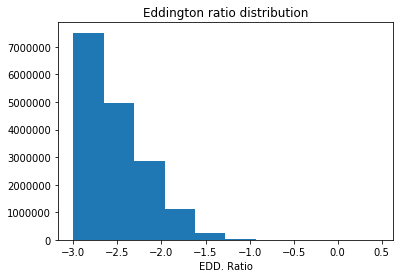

In [84]:
plt.hist(default_curves[0], lw=.05)
plt.title('Eddington ratio distribution')
plt.xlabel('EDD. Ratio')
plt.show()

## 10-panel plots

### Plot curves

In [93]:
# Delta Eddington ratio plots
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(5, 2, figsize=(20, 10), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1], 'wspace':0, 'left':0.04, 'right':0.96, 'bottom':0.05, 'top':0.95})
    
    ax[0,0].set_title('100%', fontsize=13)
    ax[0,0].tick_params(direction='in', length=6, width=1.5)
    ax[0,0].spines['top'].set_linewidth(1.5)
    ax[0,0].spines['right'].set_linewidth(1.5)
    ax[0,0].spines['bottom'].set_linewidth(1.5)
    ax[0,0].spines['left'].set_linewidth(1.5)
    
    ax[0,0].hlines(0, 0, t_log100[-1] + 0.2, linewidth=0.5)
    ax[0,0].errorbar(t_log100, means100, yerr=stands100, fmt='s', alpha=.3)
    ax[0,0].plot(t_log100[1:], best_fit100(t_log100[1:].astype(float)), ls='--', color='orange')
    
    ax[0,0].text(0, -1, smallest_point100)
    
    
    
    ax[0,1].set_title('50%', fontsize=13)
    ax[0,1].tick_params(direction='in', length=6, width=1.5)
    ax[0,1].spines['top'].set_linewidth(1.5)
    ax[0,1].spines['right'].set_linewidth(1.5)
    ax[0,1].spines['bottom'].set_linewidth(1.5)
    ax[0,1].spines['left'].set_linewidth(1.5)
    
    ax[0,1].hlines(0, 0, t_log50[-1] +0.2, linewidth=0.5)
    ax[0,1].errorbar(t_log50, means50, yerr=stands50, fmt='s', alpha=.3)
    ax[0,1].plot(t_log50[1:], best_fit50(t_log50[1:].astype(float)), ls='--', color='orange')
    
    ax[0,1].text(0, -1, smallest_point50)
    
    
    
    ax[1,0].set_title('10%', fontsize=13)
    ax[1,0].tick_params(direction='in', length=6, width=1.5)
    ax[1,0].spines['top'].set_linewidth(1.5)
    ax[1,0].spines['right'].set_linewidth(1.5)
    ax[1,0].spines['bottom'].set_linewidth(1.5)
    ax[1,0].spines['left'].set_linewidth(1.5)
    
    ax[1,0].hlines(0, 0, t_log10[-1] +0.2, linewidth=0.5)
    ax[1,0].errorbar(t_log10, means10, yerr=stands10, fmt='s', alpha=.3)
    ax[1,0].plot(t_log10[1:], best_fit10(t_log10[1:].astype(float)), ls='--', color='orange')
    
    ax[1,0].text(0, -1, smallest_point10)
    
    
    
    ax[1,1].set_title('5%', fontsize=13)
    ax[1,1].tick_params(direction='in', length=6, width=1.5)
    ax[1,1].spines['top'].set_linewidth(1.5)
    ax[1,1].spines['right'].set_linewidth(1.5)
    ax[1,1].spines['bottom'].set_linewidth(1.5)
    ax[1,1].spines['left'].set_linewidth(1.5)
    
    ax[1,1].hlines(0,  0, t_log5[-1] +0.2, linewidth=0.5)
    ax[1,1].errorbar(t_log5, means5, yerr=stands5, fmt='s', alpha=.3)
    ax[1,1].plot(t_log5[1:], best_fit5(t_log5[1:].astype(float)), ls='--', color='orange')
    
    ax[1,1].text(0, -1, smallest_point5)
    
    
    
    ax[2,0].set_title('1%', fontsize=13)
    ax[2,0].tick_params(direction='in', length=6, width=1.5)
    ax[2,0].spines['top'].set_linewidth(1.5)
    ax[2,0].spines['right'].set_linewidth(1.5)
    ax[2,0].spines['bottom'].set_linewidth(1.5)
    ax[2,0].spines['left'].set_linewidth(1.5)
    
    ax[2,0].hlines(0, 0, t_log1[-1] +0.2, linewidth=0.5)
    ax[2,0].errorbar(t_log1, means1, yerr=stands1, fmt='s', alpha=.3)
    ax[2,0].plot(t_log1[1:], best_fit1(t_log1[1:].astype(float)), ls='--', color='orange')
    
    ax[2,0].text(0, -1, smallest_point1)
    

    
    
    ax[2,1].set_title('0.5%', fontsize=13)
    ax[2,1].tick_params(direction='in', length=6, width=1.5)
    ax[2,1].spines['top'].set_linewidth(1.5)
    ax[2,1].spines['right'].set_linewidth(1.5)
    ax[2,1].spines['bottom'].set_linewidth(1.5)
    ax[2,1].spines['left'].set_linewidth(1.5)
    
    ax[2,1].hlines(0, 0, t_log05[-1] +0.2, linewidth=0.5)
    ax[2,1].errorbar(t_log05, means05, yerr=stands05, fmt='s', alpha=.3)
    ax[2,1].plot(t_log05[1:], best_fit05(t_log05[1:].astype(float)), ls='--', color='orange')
    
    ax[2,1].text(0, -1, smallest_point05)
    
    
    ax[3,0].set_title('0.1%', fontsize=13)
    ax[3,0].tick_params(direction='in', length=6, width=1.5)
    ax[3,0].spines['top'].set_linewidth(1.5)
    ax[3,0].spines['right'].set_linewidth(1.5)
    ax[3,0].spines['bottom'].set_linewidth(1.5)
    ax[3,0].spines['left'].set_linewidth(1.5)
    
    ax[3,0].hlines(0, 0, t_log01[-1] +0.2, linewidth=0.5)
    ax[3,0].errorbar(t_log01, means01, yerr=stands01, fmt='s', alpha=.3)
    ax[3,0].plot(t_log01[1:], best_fit01(t_log01[1:].astype(float)), ls='--', color='orange')
    
    ax[3,0].text(0, -1, smallest_point01)
    

    
    
    ax[3,1].set_title('0.05%', fontsize=13)
    ax[3,1].tick_params(direction='in', length=6, width=1.5)
    ax[3,1].spines['top'].set_linewidth(1.5)
    ax[3,1].spines['right'].set_linewidth(1.5)
    ax[3,1].spines['bottom'].set_linewidth(1.5)
    ax[3,1].spines['left'].set_linewidth(1.5)
    
    ax[3,1].hlines(0, 0, t_log005[-1] +0.2, linewidth=0.5)
    ax[3,1].errorbar(t_log005, means005, yerr=stands005, fmt='s', alpha=.3)
    ax[3,1].plot(t_log005[1:], best_fit005(t_log005[1:].astype(float)), ls='--', color='orange')
    
    ax[3,1].text(0, -1, smallest_point005)
    
    
    
    ax[4,0].set_title('0.01%', fontsize=13)
    ax[4,0].tick_params(direction='in', length=6, width=1.5)
    ax[4,0].spines['top'].set_linewidth(1.5)
    ax[4,0].spines['right'].set_linewidth(1.5)
    ax[4,0].spines['bottom'].set_linewidth(1.5)
    ax[4,0].spines['left'].set_linewidth(1.5)
    ax[4,0].set_xlabel('log$_{10}$(t) (time units)', fontsize=13)
    ax[4,0].set_ylabel('$\Delta$log$_{10}$(Edd. Ratio)', fontsize=13)
    
    ax[4,0].hlines(0, 0, t_log001[-1] +0.2, linewidth=0.5)
    ax[4,0].errorbar(t_log001, means001, yerr=stands001, fmt='s', alpha=.3)
    ax[4,0].plot(t_log001[1:], best_fit001(t_log001[1:].astype(float)), ls='--', color='orange')
    
    ax[4,0].text(0, -1, smallest_point001)
    
    
    
    ax[4,1].set_title('As small as possible (0.006%)', fontsize=13)
    ax[4,1].tick_params(direction='in', length=6, width=1.5)
    ax[4,1].spines['top'].set_linewidth(1.5)
    ax[4,1].spines['right'].set_linewidth(1.5)
    ax[4,1].spines['bottom'].set_linewidth(1.5)
    ax[4,1].spines['left'].set_linewidth(1.5)
    ax[4,1].set_xlabel('log$_{10}$(t) (time units)', fontsize=13)
    
    ax[4,1].hlines(0, 0, t_loginf[-1] +0.2, linewidth=0.5)
    ax[4,1].errorbar(t_loginf, meansinf, yerr=standsinf, fmt='s', alpha=.3)
    ax[4,1].plot(t_loginf[1:], best_fitinf(t_loginf[1:].astype(float)), ls='--', color='orange')
    
    ax[4,1].text(0, -1, smallest_pointinf)
    
plt.savefig('10-panel_delta_eddington_default.pdf', bbox_inches='tight')  
plt.show()

In [94]:
# Structure function plots
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(5, 2, figsize=(20, 10), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1], 'wspace':0, 'left':0.04, 'right':0.96, 'bottom':0.05, 'top':0.95})
    
    ax[0,0].set_title('100%', fontsize=13)
    ax[0,0].tick_params(direction='in', length=6, width=1.5)
    ax[0,0].spines['top'].set_linewidth(1.5)
    ax[0,0].spines['right'].set_linewidth(1.5)
    ax[0,0].spines['bottom'].set_linewidth(1.5)
    ax[0,0].spines['left'].set_linewidth(1.5)
    
    ax[0,0].hlines(0, 0, t_log100[-1] +0.2, linewidth=0.5)
    ax[0,0].plot(t_log100[1:], stands100[1:])
    
    ax[0,0].text(0, 0.6, smallest_point100)
    
    
    
    ax[0,1].set_title('50%', fontsize=13)
    ax[0,1].tick_params(direction='in', length=6, width=1.5)
    ax[0,1].spines['top'].set_linewidth(1.5)
    ax[0,1].spines['right'].set_linewidth(1.5)
    ax[0,1].spines['bottom'].set_linewidth(1.5)
    ax[0,1].spines['left'].set_linewidth(1.5)
    
    ax[0,1].hlines(0, 0, t_log50[-1] +0.2, linewidth=0.5)
    ax[0,1].plot(t_log50[1:], stands50[1:])
    
    ax[0,1].text(0, 0.6, smallest_point50)
    
    
    
    ax[1,0].set_title('10%', fontsize=13)
    ax[1,0].tick_params(direction='in', length=6, width=1.5)
    ax[1,0].spines['top'].set_linewidth(1.5)
    ax[1,0].spines['right'].set_linewidth(1.5)
    ax[1,0].spines['bottom'].set_linewidth(1.5)
    ax[1,0].spines['left'].set_linewidth(1.5)
    
    ax[1,0].hlines(0, 0, t_log10[-1] +0.2, linewidth=0.5)
    ax[1,0].plot(t_log10[1:], stands10[1:])
    
    ax[1,0].text(0, 0.6, smallest_point10)
    
    
    
    ax[1,1].set_title('5%', fontsize=13)
    ax[1,1].tick_params(direction='in', length=6, width=1.5)
    ax[1,1].spines['top'].set_linewidth(1.5)
    ax[1,1].spines['right'].set_linewidth(1.5)
    ax[1,1].spines['bottom'].set_linewidth(1.5)
    ax[1,1].spines['left'].set_linewidth(1.5)
    
    ax[1,1].hlines(0,  0, t_log5[-1] +0.2, linewidth=0.5)
    ax[1,1].plot(t_log5[1:], stands5[1:])
    
    ax[1,1].text(0, 0.6, smallest_point5)
    
    
    
    ax[2,0].set_title('1%', fontsize=13)
    ax[2,0].tick_params(direction='in', length=6, width=1.5)
    ax[2,0].spines['top'].set_linewidth(1.5)
    ax[2,0].spines['right'].set_linewidth(1.5)
    ax[2,0].spines['bottom'].set_linewidth(1.5)
    ax[2,0].spines['left'].set_linewidth(1.5)
    
    ax[2,0].hlines(0, 0, t_log1[-1] +0.2, linewidth=0.5)
    ax[2,0].plot(t_log1[1:], stands1[1:])
    
    ax[2,0].text(0, 0.6, smallest_point1)
    

    
    
    ax[2,1].set_title('0.5%', fontsize=13)
    ax[2,1].tick_params(direction='in', length=6, width=1.5)
    ax[2,1].spines['top'].set_linewidth(1.5)
    ax[2,1].spines['right'].set_linewidth(1.5)
    ax[2,1].spines['bottom'].set_linewidth(1.5)
    ax[2,1].spines['left'].set_linewidth(1.5)
    
    ax[2,1].hlines(0, 0, t_log05[-1] +0.2, linewidth=0.5)
    ax[2,1].plot(t_log05[1:], stands05[1:])
    
    ax[2,1].text(0, 0.6, smallest_point05)
    
    
    ax[3,0].set_title('0.1%', fontsize=13)
    ax[3,0].tick_params(direction='in', length=6, width=1.5)
    ax[3,0].spines['top'].set_linewidth(1.5)
    ax[3,0].spines['right'].set_linewidth(1.5)
    ax[3,0].spines['bottom'].set_linewidth(1.5)
    ax[3,0].spines['left'].set_linewidth(1.5)
    
    ax[3,0].hlines(0, 0, t_log01[-1] +0.2, linewidth=0.5)
    ax[3,0].plot(t_log01[1:], stands01[1:])
    
    ax[3,0].text(0, 0.6, smallest_point01)
    

    
    
    ax[3,1].set_title('0.05%', fontsize=13)
    ax[3,1].tick_params(direction='in', length=6, width=1.5)
    ax[3,1].spines['top'].set_linewidth(1.5)
    ax[3,1].spines['right'].set_linewidth(1.5)
    ax[3,1].spines['bottom'].set_linewidth(1.5)
    ax[3,1].spines['left'].set_linewidth(1.5)
    
    ax[3,1].hlines(0, 0, t_log005[-1] +0.2, linewidth=0.5)
    ax[3,1].plot(t_log005[1:], stands005[1:])
    
    ax[3,1].text(0, 0.6, smallest_point005)
    
    
    
    ax[4,0].set_title('0.01%', fontsize=13)
    ax[4,0].tick_params(direction='in', length=6, width=1.5)
    ax[4,0].spines['top'].set_linewidth(1.5)
    ax[4,0].spines['right'].set_linewidth(1.5)
    ax[4,0].spines['bottom'].set_linewidth(1.5)
    ax[4,0].spines['left'].set_linewidth(1.5)
    ax[4,0].set_xlabel('log$_{10}$(t) (time units)', fontsize=13)
    ax[4,0].set_ylabel('Size of data spread', fontsize=13)
    
    ax[4,0].hlines(0, 0, t_log001[-1] +0.2, linewidth=0.5)
    ax[4,0].plot(t_log001[1:], stands001[1:])
    
    ax[4,0].text(0, 0.6, smallest_point001)
    
    
    
    ax[4,1].set_title('As small as possible (0.006%)', fontsize=13)
    ax[4,1].tick_params(direction='in', length=6, width=1.5)
    ax[4,1].spines['top'].set_linewidth(1.5)
    ax[4,1].spines['right'].set_linewidth(1.5)
    ax[4,1].spines['bottom'].set_linewidth(1.5)
    ax[4,1].spines['left'].set_linewidth(1.5)
    ax[4,1].set_xlabel('log$_{10}$(t) (time units)', fontsize=13)
    
    ax[4,1].hlines(0, 0, t_loginf[-1] +0.2, linewidth=0.5)
    ax[4,1].plot(t_loginf[1:], standsinf[1:])
    
    ax[4,1].text(0, 0.6, smallest_pointinf)
    
plt.savefig('10-panel_structure_functions_default.pdf', bbox_inches='tight')  
plt.show()

### Create curves

In [91]:
t_log100, means100, stands100, best_fit100, smallest_point100 = generate_curve(brightest_percent=100)

t_log50, means50, stands50, best_fit50, smallest_point50 = generate_curve(brightest_percent=50)

t_log10, means10, stands10, best_fit10, smallest_point10 = generate_curve(brightest_percent=10)

t_log5, means5, stands5, best_fit5, smallest_point5 = generate_curve(brightest_percent=5)

t_log1, means1, stands1, best_fit1, smallest_point1 = generate_curve(brightest_percent=1)

t_log05, means05, stands05, best_fit05, smallest_point05 = generate_curve(brightest_percent=0.5)

t_log01, means01, stands01, best_fit01, smallest_point01 = generate_curve(brightest_percent=0.1)

t_log005, means005, stands005, best_fit005, smallest_point005 = generate_curve(brightest_percent=0.05)

t_log001, means001, stands001, best_fit001, smallest_point001 = generate_curve(brightest_percent=0.01)

t_loginf, meansinf, standsinf, best_fitinf, smallest_pointinf = generate_curve(brightest_percent=0.006)


  5%|▌         | 1/20 [00:00<00:05,  3.47it/s]


100%|██████████| 20/20 [00:02<00:00,  6.03it/s]


 35%|███▌      | 7/20 [00:01<00:03,  3.80it/s]


 20%|██        | 4/20 [00:00<00:02,  5.72it/s]


 33%|███▎      | 7/21 [00:00<00:02,  6.63it/s]


 95%|█████████▌| 19/20 [00:01<00:00,  5.92it/s]


100%|██████████| 1001/1001 [00:00<00:00, 2083.98it/s]

## 4-Line plots

### Plot curves

In [12]:
# PSD regime determination plot
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1, figsize=(20, 10))
    
    ax.set_title('Change in log(Edd. Ratio) as a function of chosen percent ', fontsize=13)
    ax.tick_params(direction='in', length=6, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.set_xlabel('Percentage of total data', fontsize=13)
    ax.set_xlim([101, -1])
    ax.set_ylabel('$\Delta$log$_{10}$(Edd. Ratio)', fontsize=13)
    
    ax.plot(x, log_t_1, label='log(t) = 1')
    ax.plot(x, log_t_2, label='log(t) = 2')
    ax.plot(x, log_t_3, label='log(t) = 3')
    ax.plot(x, log_t_4, label='log(t) = 4')
    
    ax.legend()
    
plt.savefig('4-line_delta_eddington_default.pdf', bbox_inches='tight')  
plt.show()

In [13]:
# Structure functions in a strange space
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1, figsize=(20, 10))
    
    ax.set_title('Change in log(Edd. Ratio) as a function of chosen percent ', fontsize=13)
    ax.tick_params(direction='in', length=6, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.set_xlabel('Percentage of total data', fontsize=13)
    ax.set_xlim([101, -1])
    ax.set_ylabel('$\Delta$log$_{10}$(Edd. Ratio)', fontsize=13)
    
    ax.plot(x, log_t_1_stands, label='log(t) = 1')
    ax.plot(x, log_t_2_stands, label='log(t) = 2')
    ax.plot(x, log_t_3_stands, label='log(t) = 3')
    ax.plot(x, log_t_4_stands, label='log(t) = 4')
    
    ax.legend()
    
plt.savefig('4-line_structure_function_default.pdf', bbox_inches='tight')  
plt.show()

### Create curves

In [8]:
t_log100, means100, stands100, best_fit100, smallest_point100 = generate_curve(brightest_percent=100)

t_log50, means50, stands50, best_fit50, smallest_point50 = generate_curve(brightest_percent=50)

t_log10, means10, stands10, best_fit10, smallest_point10 = generate_curve(brightest_percent=10)

t_log5, means5, stands5, best_fit5, smallest_point5 = generate_curve(brightest_percent=5)

t_log1, means1, stands1, best_fit1, smallest_point1 = generate_curve(brightest_percent=1)

t_log05, means05, stands05, best_fit05, smallest_point05 = generate_curve(brightest_percent=0.5)

t_log01, means01, stands01, best_fit01, smallest_point01 = generate_curve(brightest_percent=0.1)

t_log005, means005, stands005, best_fit005, smallest_point005 = generate_curve(brightest_percent=0.05)

t_log001, means001, stands001, best_fit001, smallest_point001 = generate_curve(brightest_percent=0.01)

t_loginf, meansinf, standsinf, best_fitinf, smallest_pointinf = generate_curve(brightest_percent=0.006)

100%|██████████| 1001/1001 [00:00<00:00, 2022.27it/s]


In [9]:
log_t_1 = [means100[np.where(t_log100==1)[0][0]], means50[np.where(t_log50==1)[0][0]], means10[np.where(t_log10==1)[0][0]], means5[np.where(t_log5==1)[0][0]], means1[np.where(t_log1==1)[0][0]], means05[np.where(t_log05==1)[0][0]], means01[np.where(t_log01==1)[0][0]], means005[np.where(t_log005==1)[0][0]], means001[np.where(t_log001==1)[0][0]], meansinf[np.where(t_loginf==1)[0][0]]]
log_t_2 = [means100[np.where(t_log100==2)[0][0]], means50[np.where(t_log50==2)[0][0]], means10[np.where(t_log10==2)[0][0]], means5[np.where(t_log5==2)[0][0]], means1[np.where(t_log1==2)[0][0]], means05[np.where(t_log05==2)[0][0]], means01[np.where(t_log01==2)[0][0]], means005[np.where(t_log005==2)[0][0]], means001[np.where(t_log001==2)[0][0]], meansinf[np.where(t_loginf==2)[0][0]]]
log_t_3 = [means100[np.where(t_log100==3)[0][0]], means50[np.where(t_log50==3)[0][0]], means10[np.where(t_log10==3)[0][0]], means5[np.where(t_log5==3)[0][0]], means1[np.where(t_log1==3)[0][0]], means05[np.where(t_log05==3)[0][0]], means01[np.where(t_log01==3)[0][0]], means005[np.where(t_log005==3)[0][0]], means001[np.where(t_log001==3)[0][0]], meansinf[np.where(t_loginf==3)[0][0]]]
log_t_4 = [means100[np.where(t_log100==4)[0][0]], means50[np.where(t_log50==4)[0][0]], means10[np.where(t_log10==4)[0][0]], means5[np.where(t_log5==4)[0][0]], means1[np.where(t_log1==4)[0][0]], means05[np.where(t_log05==4)[0][0]], means01[np.where(t_log01==4)[0][0]], means005[np.where(t_log005==4)[0][0]], means001[np.where(t_log001==4)[0][0]], meansinf[np.where(t_loginf==4)[0][0]]]

log_t_1_stands = [stands100[np.where(t_log100==1)[0][0]], stands50[np.where(t_log50==1)[0][0]], stands10[np.where(t_log10==1)[0][0]], stands5[np.where(t_log5==1)[0][0]], stands1[np.where(t_log1==1)[0][0]], stands05[np.where(t_log05==1)[0][0]], stands01[np.where(t_log01==1)[0][0]], stands005[np.where(t_log005==1)[0][0]], stands001[np.where(t_log001==1)[0][0]], standsinf[np.where(t_loginf==1)[0][0]]]
log_t_2_stands = [stands100[np.where(t_log100==2)[0][0]], stands50[np.where(t_log50==2)[0][0]], stands10[np.where(t_log10==2)[0][0]], stands5[np.where(t_log5==2)[0][0]], stands1[np.where(t_log1==2)[0][0]], stands05[np.where(t_log05==2)[0][0]], stands01[np.where(t_log01==2)[0][0]], stands005[np.where(t_log005==2)[0][0]], stands001[np.where(t_log001==2)[0][0]], standsinf[np.where(t_loginf==2)[0][0]]]
log_t_3_stands = [stands100[np.where(t_log100==3)[0][0]], stands50[np.where(t_log50==3)[0][0]], stands10[np.where(t_log10==3)[0][0]], stands5[np.where(t_log5==3)[0][0]], stands1[np.where(t_log1==3)[0][0]], stands05[np.where(t_log05==3)[0][0]], stands01[np.where(t_log01==3)[0][0]], stands005[np.where(t_log005==3)[0][0]], stands001[np.where(t_log001==3)[0][0]], standsinf[np.where(t_loginf==3)[0][0]]]
log_t_4_stands = [stands100[np.where(t_log100==4)[0][0]], stands50[np.where(t_log50==4)[0][0]], stands10[np.where(t_log10==4)[0][0]], stands5[np.where(t_log5==4)[0][0]], stands1[np.where(t_log1==4)[0][0]], stands05[np.where(t_log05==4)[0][0]], stands01[np.where(t_log01==4)[0][0]], stands005[np.where(t_log005==4)[0][0]], stands001[np.where(t_log001==4)[0][0]], standsinf[np.where(t_loginf==4)[0][0]]]

x = [100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.006]